In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

Load data as `msgpack`

In [31]:
data = pd.read_msgpack("test.msgpack")
df = pd.DataFrame.from_dict(data)
df.head()

,F,Msgtype,PWM,Rc,Rw,T,T0,TimeStamp
0,2.072126,2,0,26.200001,0.4,28.025763,27.793253,39.987698
1,4.033395,2,0,26.200001,0.4,28.019743,27.783648,40.001297
2,1.584638,2,0,26.200001,0.4,28.019743,27.783648,40.011536
3,2.857643,2,0,26.200001,0.4,28.019743,27.783648,40.021515
4,0.862415,2,0,26.200001,0.4,28.025763,27.789715,40.040520


In [32]:
df.columns = ["f", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
df.head()
if(df.iloc[0].timestamp > 0):
    df.timestamp -= df.iloc[0].timestamp

Clean $ F_t < F_{min} $ (OPTIONAL)

In [33]:
#df.drop(df[df.f < 0].index, inplace=True)

Replace PWM$=0$ with PWM$=NaN$

In [34]:
df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)

## Graphs

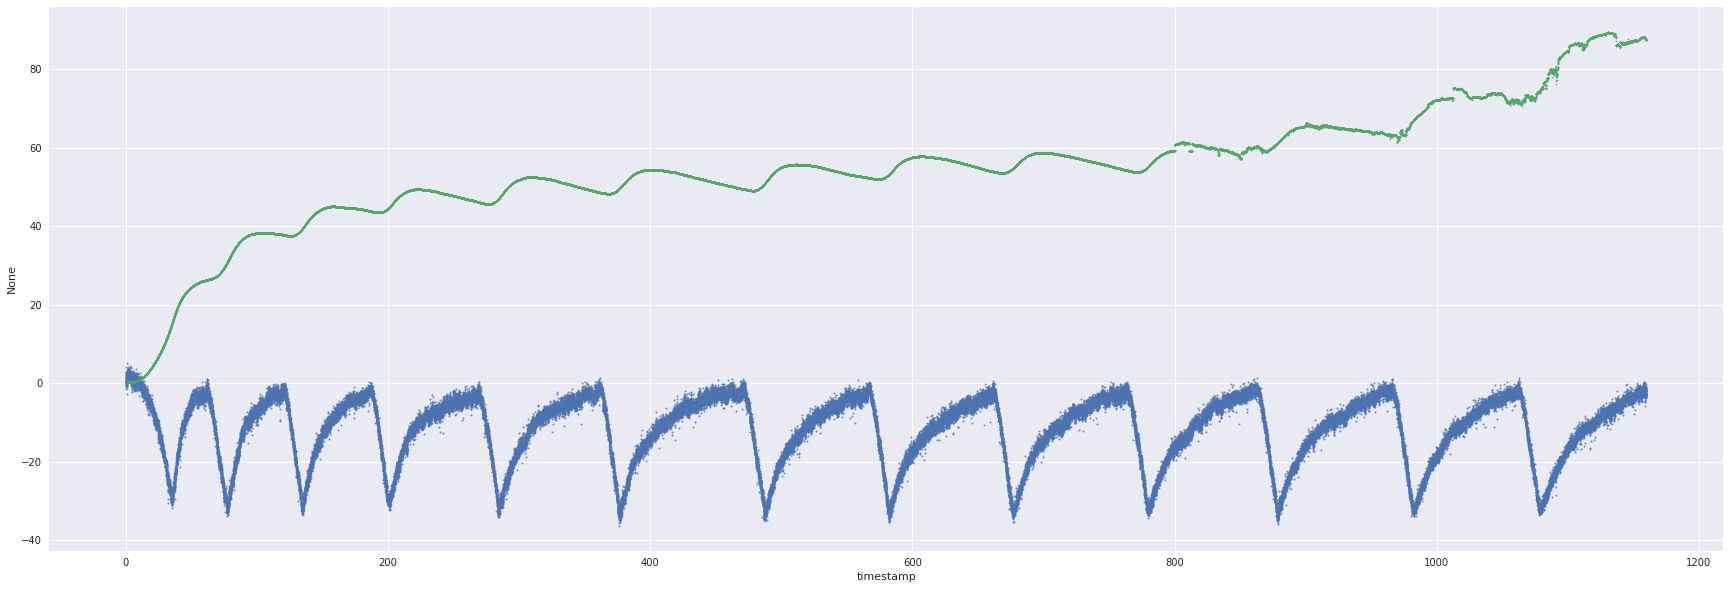

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
sns.regplot(df.timestamp, df.f, fit_reg=False, scatter_kws={"s": 4})
sns.regplot(df.timestamp, df.t-df.t0, fit_reg=False, scatter_kws={"s": 2})

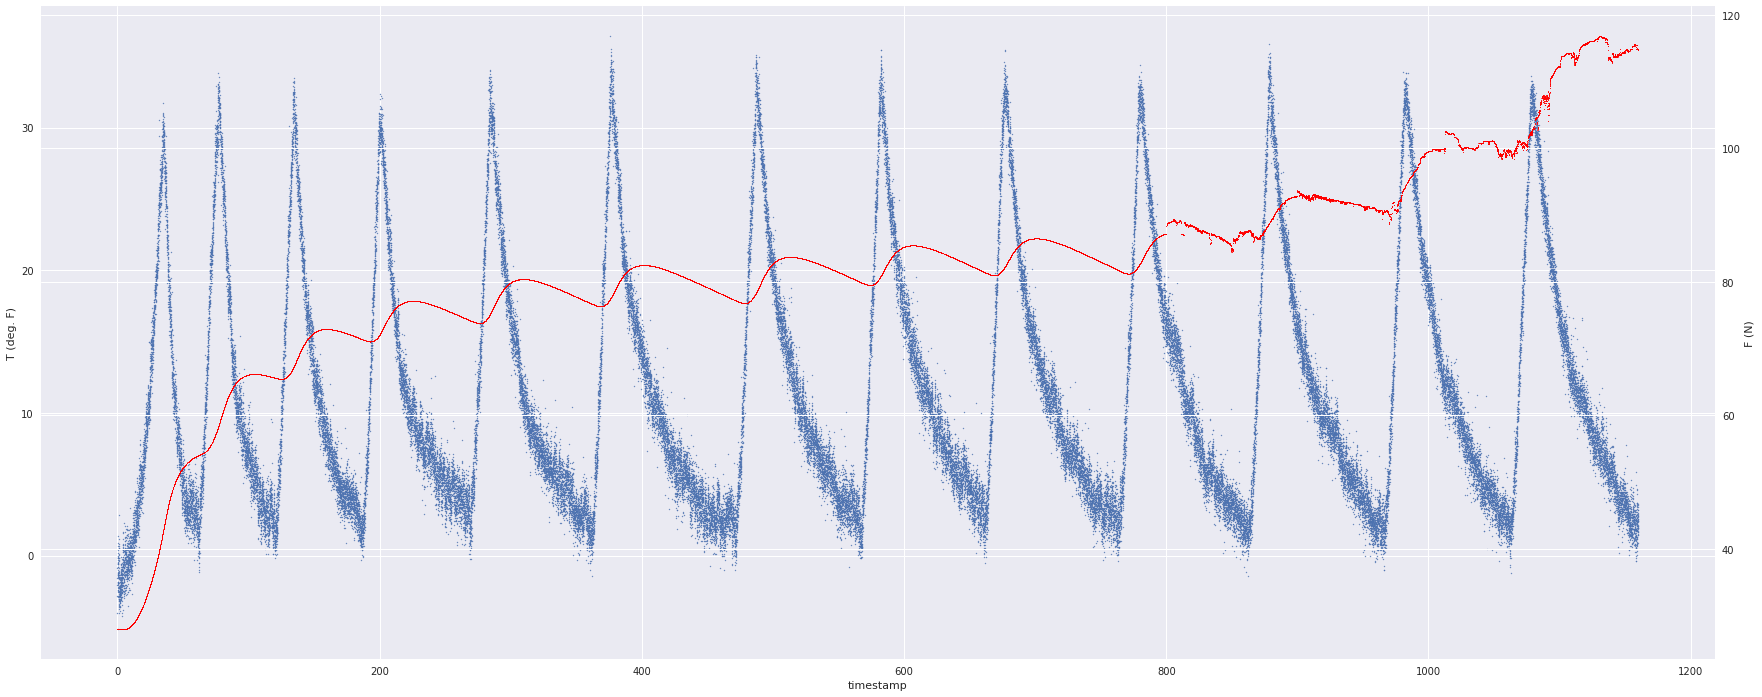

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(30,12))
sns.regplot(df.timestamp, -df.f, ax=ax, fit_reg=False, scatter_kws={"s": 2})
ax2 = ax.twinx()
sns.regplot(df.timestamp, df.t, ax=ax2, fit_reg=False, scatter_kws={"s": 1, "color": "red"})

ax.set_ylabel('T (deg. F)')
ax2.set_ylabel('F (N)');  # relative to plt.rcParams['font.size']

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

$$ R^2 = 1 - \frac{\textrm{sum of squared residuals}}{n\times\sigma^2} $$
$$ \in (-\infty, 1] $$

### Moving averages (smoothing)
$$ \hat{y_t} = \frac{1}{k}\sum_{1}^k y_{t-n} $$

In [36]:
ma = lambda s, n: np.average(s[-n:])

In [245]:
def plot_ma(s, win, ax, alpha=1.0, plot_intervals=False, scale=1, get_ma=False):
    ma = s.rolling(window=win).mean()
    if plot_intervals:
        mae = mean_absolute_error(s[win:], ma[win:])
        std = np.std(s[win:] - ma[win:])
        lower = ma - (mae+scale*std)
        upper = ma + (mae+scale*std)
        ax.plot(lower, "r--", alpha=alpha)
        ax.plot(upper, "r--", alpha=alpha)
    ax.plot(ma, alpha=alpha)
    if get_ma:
        return ma

In [47]:
df.head()

,f,msgtype,pwm,rc,rw,t,t0,timestamp
0,2.072126,2,NaN,26.200001,0.4,28.025763,27.793253,0.000000
1,4.033395,2,NaN,26.200001,0.4,28.019743,27.783648,0.013599
2,1.584638,2,NaN,26.200001,0.4,28.019743,27.783648,0.023838
3,2.857643,2,NaN,26.200001,0.4,28.019743,27.783648,0.033817
4,0.862415,2,NaN,26.200001,0.4,28.025763,27.789715,0.052822


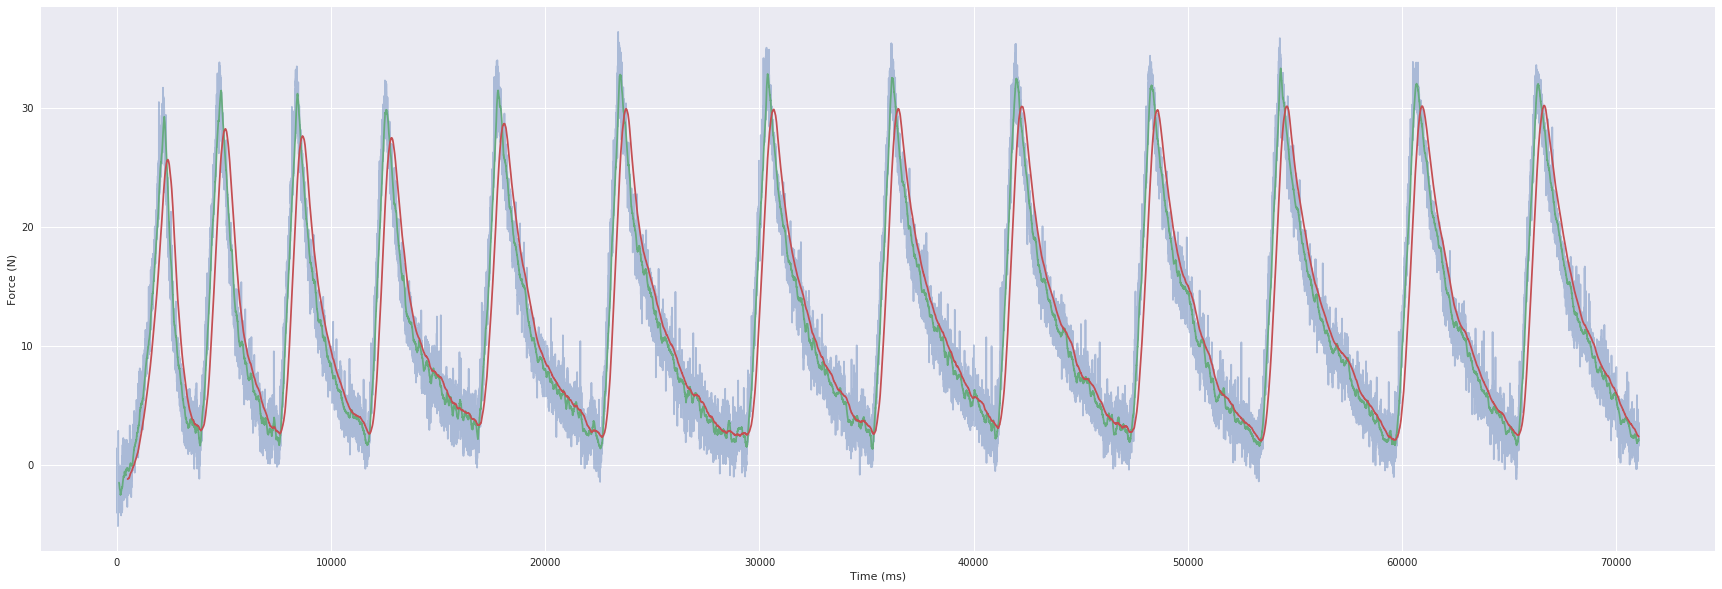

In [101]:
K_ALPHA = 0.4
fig, axes = plt.subplots(1, 1, figsize=(30,10))
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
for i, win in enumerate([1, 100, 500]):
    plot_ma(-df.f, int(win), axes, min(K_ALPHA*(i+1), 1))

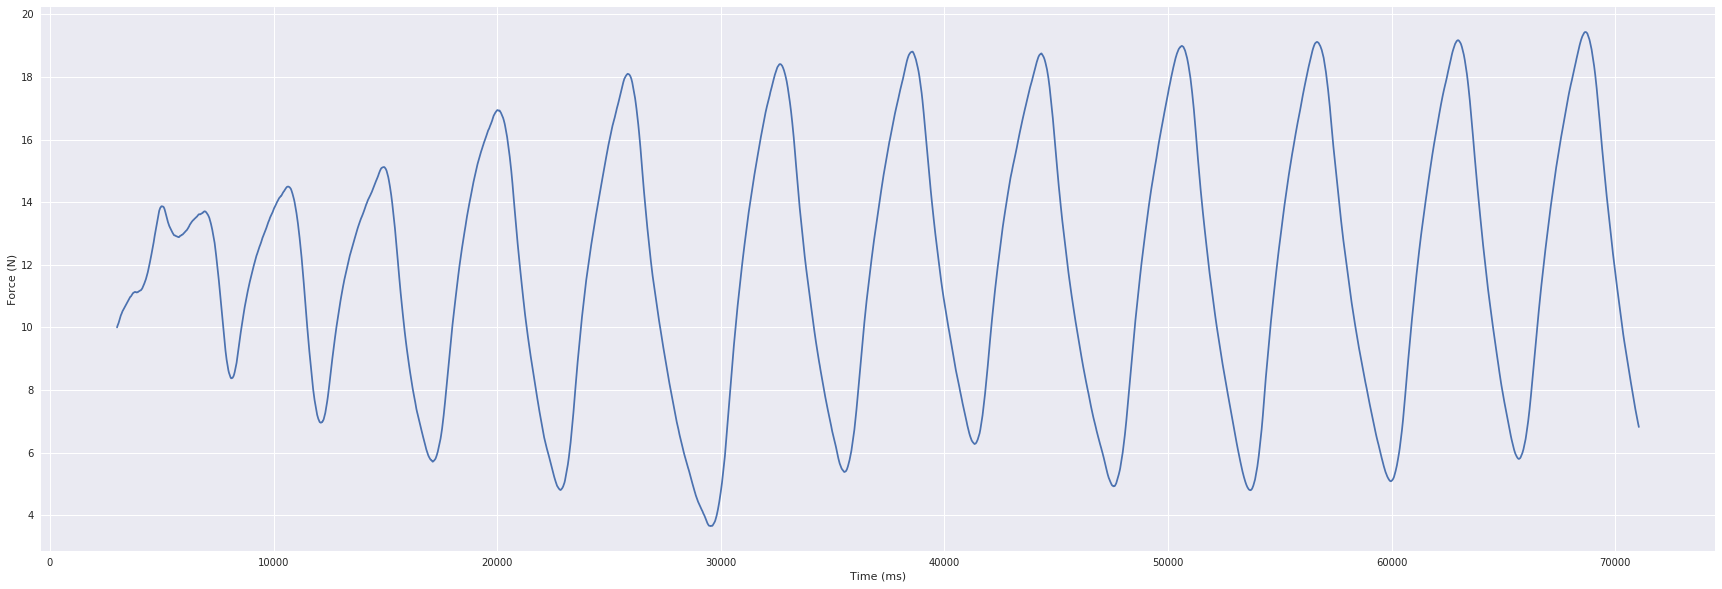

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plot_ma(-df.f, 3000, ax, 1)

### with MAE confidence intervals
$$ \frac{\sum_{i=1}^n \vert y_i - \hat{y_i} \vert}{n} $$

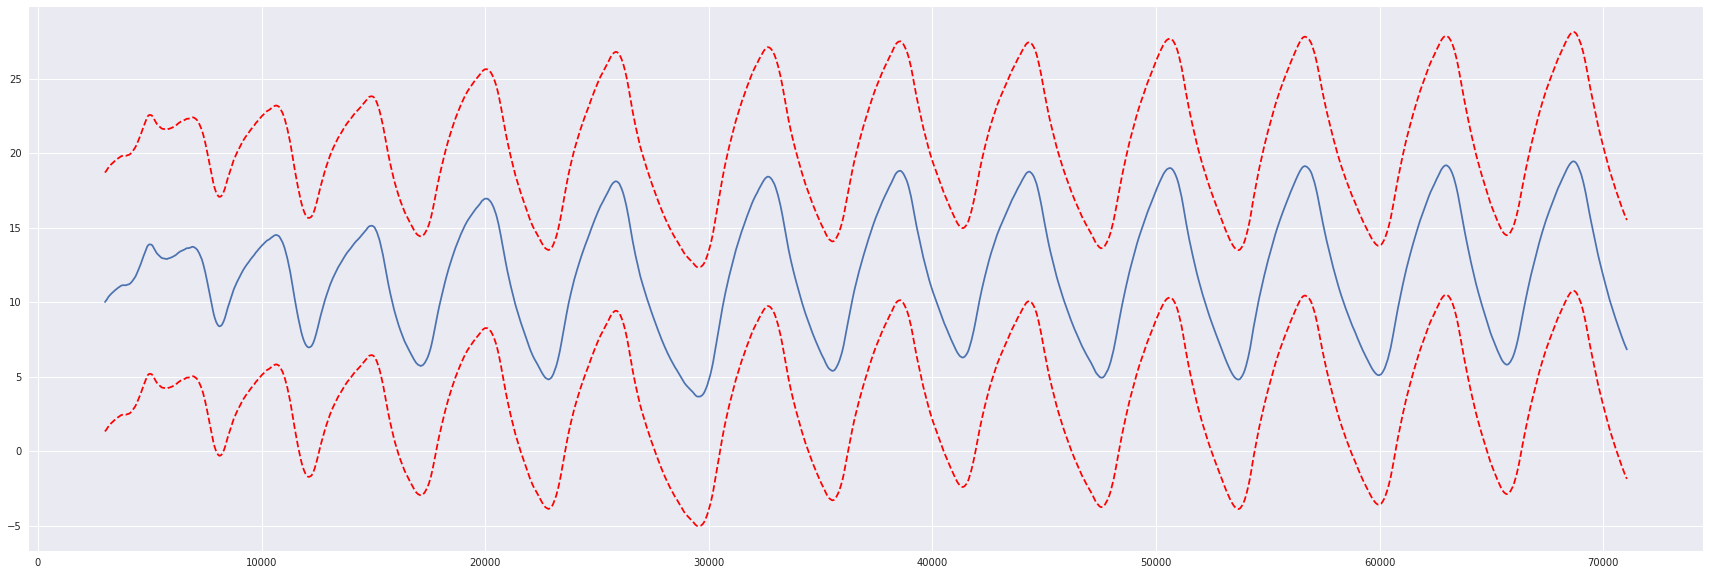

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plot_ma(-df.f, 3000, ax, 1, plot_intervals=True, scale=0.1)

### exponential smoothing
$$ \hat{y_t} = \alpha y_t + (1-\alpha) \hat{y_{t-1}} $$
$$ a\rightarrow 0 \textrm{: smoother (weigh prev. observation more)} $$

In [139]:
def exp_smo(s, a):
    res = [s[0]]
    for i in range(1, len(s)):
        res.append(a*s[i] + (1-a)*res[i-1])
    return res

In [165]:
def plot_exp_smo(s, a, ax, alpha=1):
    ax.plot(exp_smo(s, a), alpha=a)

fig, ax = plt.subplots(1, 1, figsize=(30,10))
for a in [0.05, 0.3, 1.0]:
    plot_exp_smo(-df.f, a, ax, alpha=0.2)

In [171]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [173]:
def plot_autocorr(y, ax, lags=None):
    p_val = adfuller(y) # for fun
    plot_acf(y, lags=lags, ax=ax)

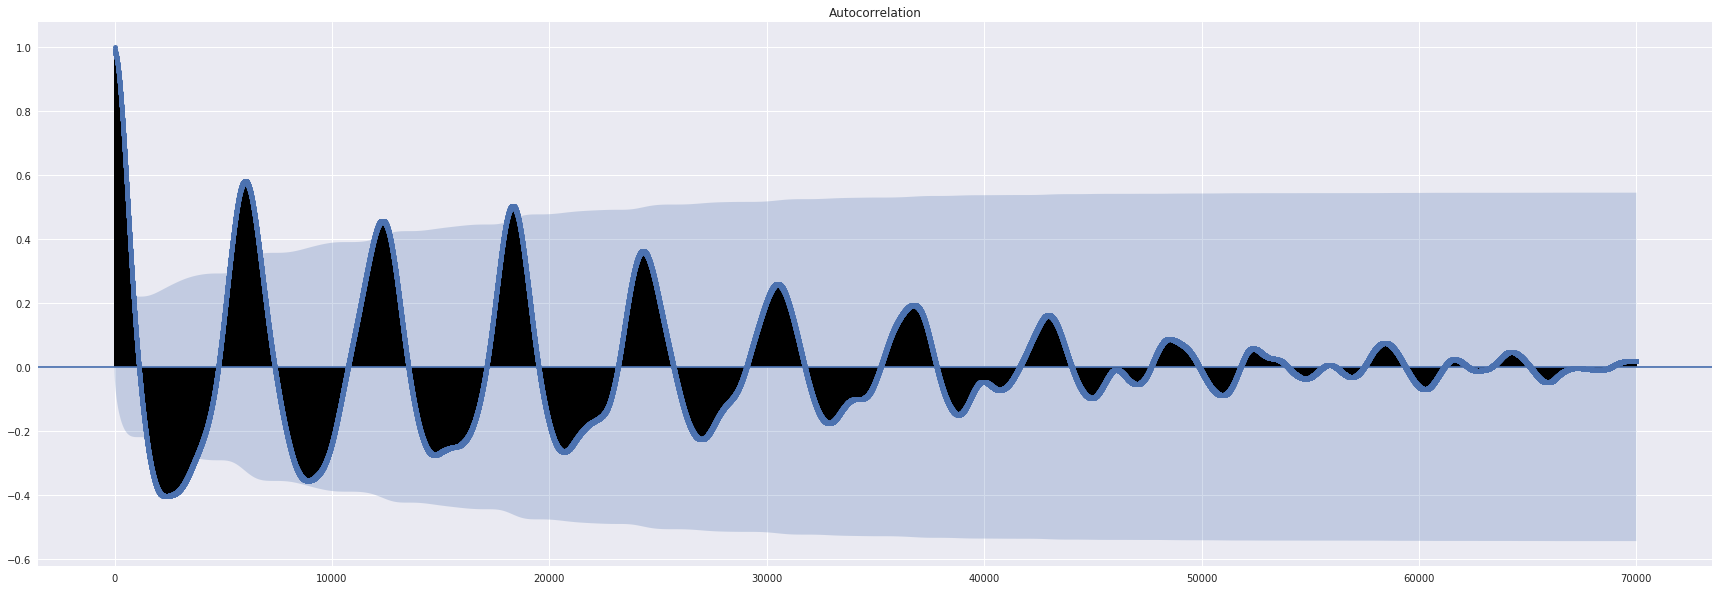

In [310]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plot_autocorr(df.f, ax, lags=70000)

### quick regression

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [284]:
def ts_train_test_split(X, y, test_size):
    test_i = int(len(X) * (1-test_size))
    X = X.dropna()
    y = y.dropna()
    X_train, X_test = X.iloc[:test_i], X.iloc[test_i:]
    y_train, y_test = y.iloc[:test_i], y.iloc[test_i:]
    X_train, X_test = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)
    y_train, y_test = y_train.values.reshape(-1,1), y_test.values.reshape(-1,1)
    return X_train, X_test, y_train, y_test

In [285]:
df.columns

Index(['f', 'msgtype', 'pwm', 'rc', 'rw', 't', 't0', 'timestamp'], dtype='object')

In [286]:
X = df['timestamp'].dropna()
y = df['f'].dropna()

In [287]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)

In [288]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [289]:
pred = lr.predict(X_test)

In [290]:
#fig, ax = plt.subplots(1, 1, figsize=(30,10))
#ax.plot(pred)
#ax.plot(y_test)

In [300]:
from sklearn.preprocessing import PolynomialFeatures

In [301]:
poly = PolynomialFeatures(3)
ma = plot_ma(-df.f, 500, ax, 1, get_ma=True)

In [303]:
X, y = df[['timestamp', 'f']], df['f']
poly.fit_transform(X)
X = X.timestamp
X_train, X_test, y_train, y_test = ts_train_test_split(X, ma, test_size=0.1)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

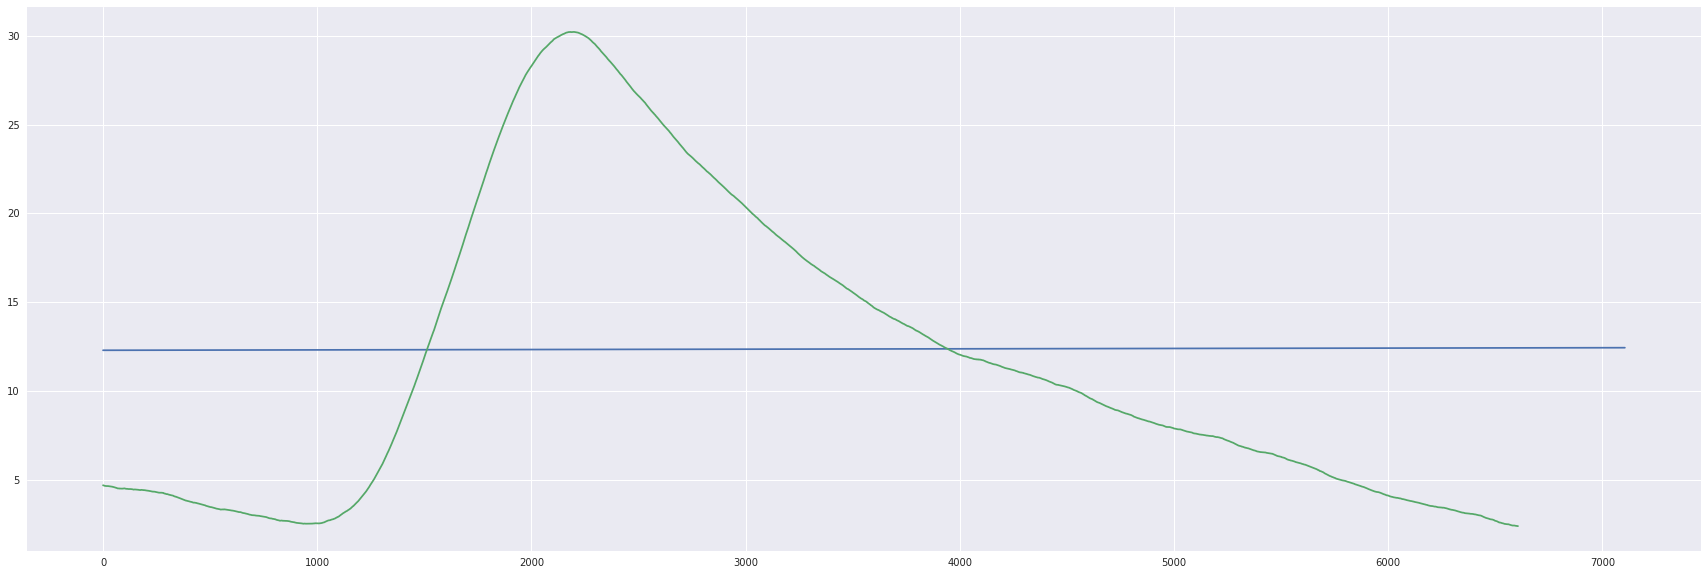

In [305]:
pred = lr.predict(X_test)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.plot(pred)
ax.plot(y_test)

### ARMA

In [311]:
from statsmodels.tsa.arima_model import ARMA

In [314]:
Xf = df.f
Xf.index = pd.to_datetime(df.timestamp, unit='ms')

In [316]:
model = ARMA(Xf, order=(1,0))
result = model.fit()

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


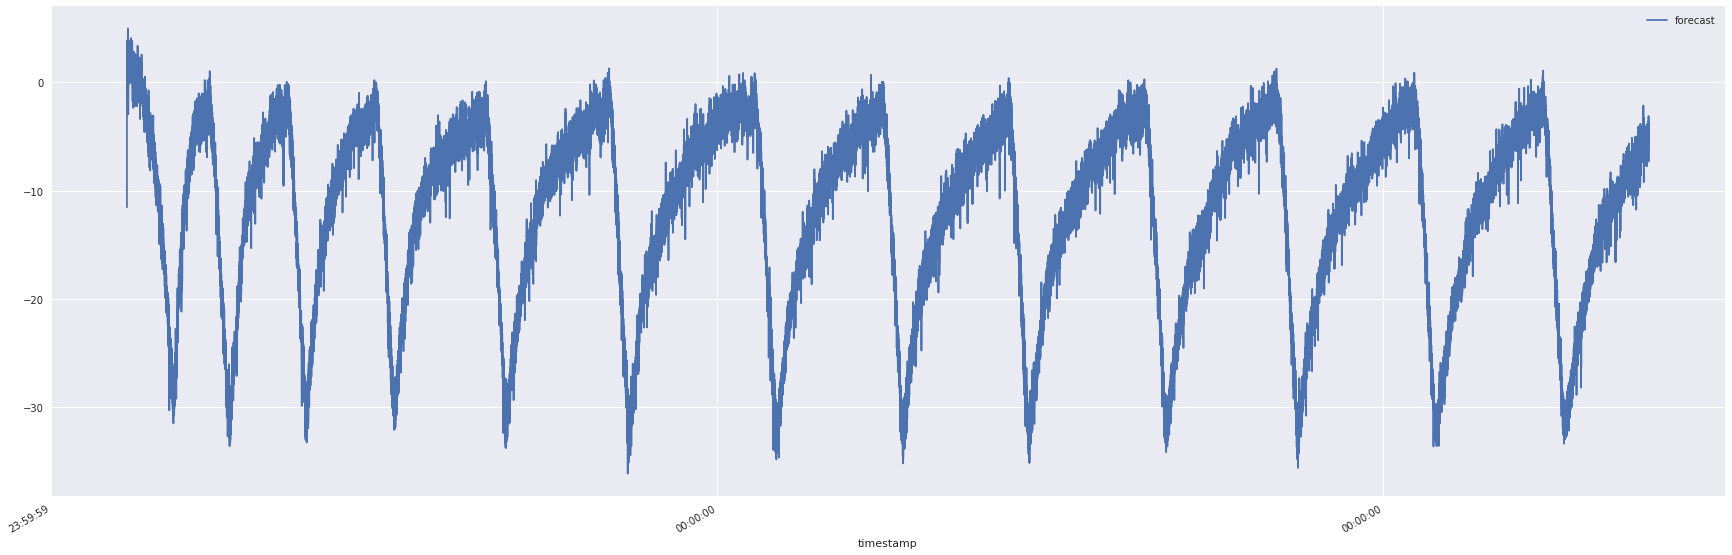

In [324]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
result.plot_predict(start=0, end=70000, ax=ax, plot_insample=False)
plt.show()

In [441]:
Xma = pd.DataFrame(data=ma)
Xma.index = pd.to_datetime(df.timestamp, unit='ms')
Xma = Xma.replace([np.inf, -np.inf], np.nan).dropna()
model = ARMA(Xma, order=(1,0))
result = model.fit()

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


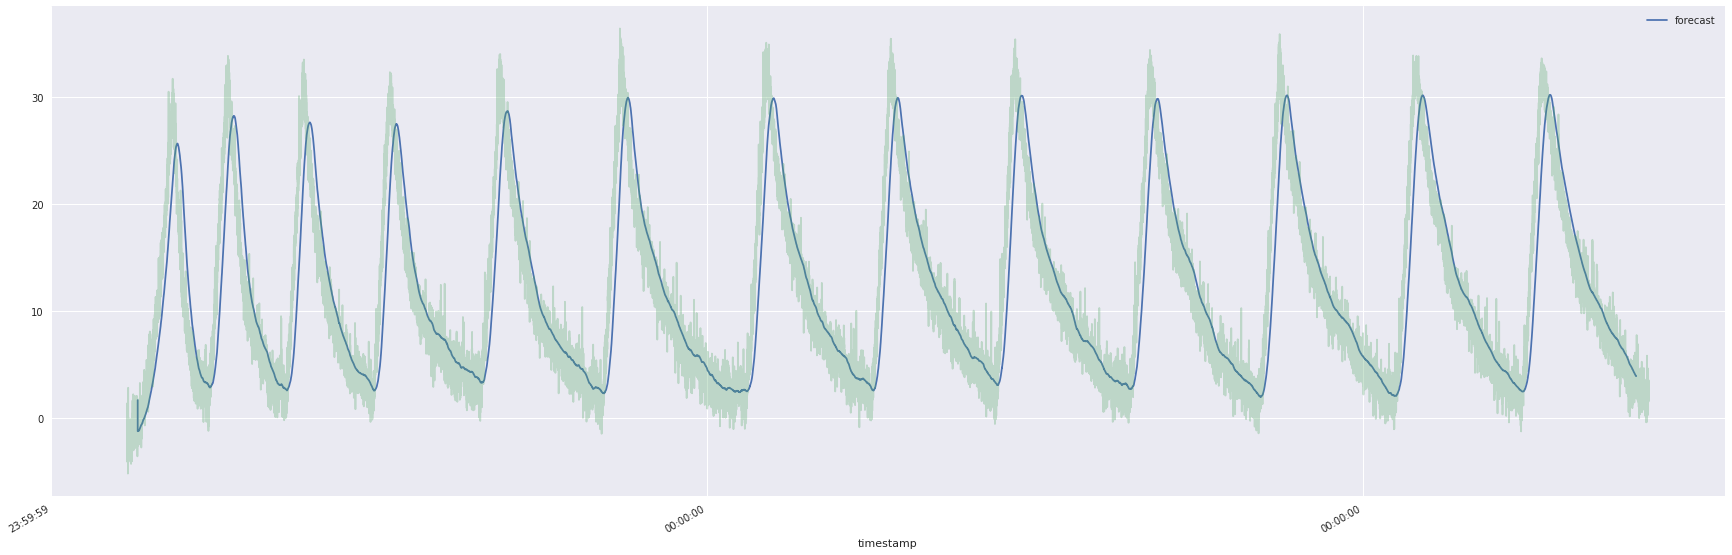

In [442]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
result.plot_predict(start=0, end=70000, ax=ax, plot_insample=False)
ax.plot(-df.f, alpha=0.3)
plt.show()

### RMSE
$$ \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y_i})^2} $$

In [443]:
rmse = lambda y, yhat: np.sqrt(((y-yhat)**2).mean())
mae = lambda y, yhat: np.abs(y-yhat).mean()

In [444]:
pred = result.predict(start=0, end=70000)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [375]:
rmse(pred.f, Xf.f)

28.448979096177236

In [378]:
mae(pred.f, Xf.f)

23.452899800206044

### TTS

In [463]:
X = Xma
#X['timestamp'] = Xma.index.to_series()
#X.reset_index(inplace=True, drop=True)

In [464]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, X.f, test_size=0.3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [466]:
X_train = X_train[0::2]
X_test = X_test[0::2]

## TODO
#X_train.index = pd.to_datetime(df.timestamp, unit='ms')

In [467]:
model = ARMA(X_train, order=(1,0))
result = model.fit()

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


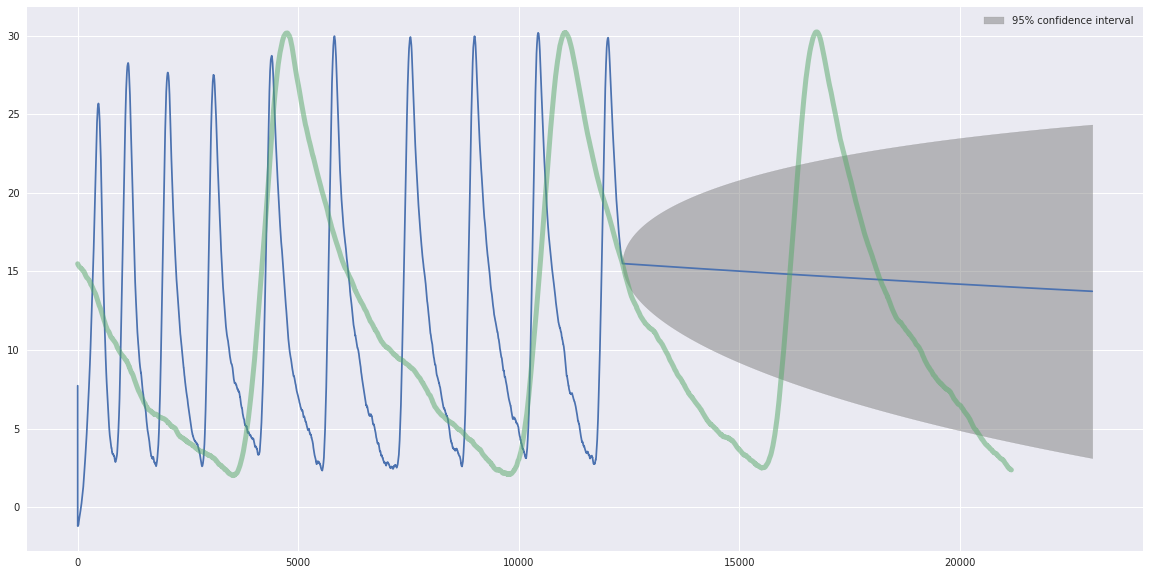

In [493]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
result.plot_predict(start=0, end=23000, ax=ax, plot_insample=False)
ax.plot(y_test, alpha=0.5, linewidth=5)